 Подсасываю репозиторий с кодом в colab

In [1]:
!git clone https://github.com/cloneofsimo/minDiffusion.git

fatal: destination path 'minDiffusion' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Подгружаю код

In [3]:
import sys

sys.path.insert(0, "/content/minDiffusion")

In [4]:
import torch

from mindiffusion.unet import NaiveUnet
from mindiffusion.ddpm import DDPM

In [5]:
model = NaiveUnet(3, 3, n_feat=128)
print(model)

NaiveUnet(
  (init_conv): Conv3(
    (main): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 128, eps=1e-05, affine=True)
      (2): ReLU()
    )
    (conv): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 128, eps=1e-05, affine=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(8, 128, eps=1e-05, affine=True)
      (5): ReLU()
    )
  )
  (down1): UnetDown(
    (model): Sequential(
      (0): Conv3(
        (main): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 128, eps=1e-05, affine=True)
          (2): ReLU()
        )
        (conv): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 128, eps=1e-05, affine=True)
          (2): ReLU()
 

Подсасываю датасет. Датасет выбрала вот этот https://github.com/phelber/eurosat, т.к. с ним немного работала и размер изображения под задачу подходит). Там 13 каналов, решила, что нам нужно только RGB.

In [6]:
!mkdir -p /content/eurosat-rgb
!wget https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip
!unzip EuroSAT_RGB.zip -d /content/eurosat-rgb
!rm EuroSAT_RGB.zip

--2023-04-09 21:56:04--  https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: ‘EuroSAT_RGB.zip’

EuroSAT_RGB.zip     100%[===================>]  90.27M  13.7MB/s    in 7.9s    

2023-04-09 21:56:14 (11.4 MB/s) - ‘EuroSAT_RGB.zip’ saved [94658721/94658721]

Archive:  EuroSAT_RGB.zip
replace /content/eurosat-rgb/EuroSAT_RGB/Forest/Forest_864.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Для работы со спутниковыми снимками есть пакет torchsat, я с ним немного работала, поэтому не буду изобретать велосипед)

In [7]:
!pip install torchsat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


У модуля так себе документация, поэтому можно глянуть код.

In [8]:
import inspect

from torchsat.datasets.eurosat import EuroSAT

In [9]:
lines = inspect.getsource(EuroSAT)
print(lines)

class EuroSAT(DatasetFolder):
    url_rgb = 'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
    url_allband = 'http://madm.dfki.de/files/sentinel/EuroSATallBands.zip'

    def __init__(self, root, mode='RGB', download=False, **kwargs):
        if mode not in ['RGB', 'AllBand']:
            raise ValueError('{} is not suppport mode, replace with RGB or AllBand'.format(self.mode))

        if mode == 'RGB':
            self.loader = pil_loader
            self.extensions = ['.jpg', '.jpeg']
        else:
            self.loader = tifffile_loader
            self.extensions = ['.tif', '.tiff']
            root = os.path.join(root, 'images/remote_sensing/otherDatasets/sentinel_2/tif')

        classes = list(CLASSES_TO_IDX.keys())

        super(EuroSAT, self).__init__(root, self.loader, self.extensions, 
        classes=classes, class_to_idx=CLASSES_TO_IDX, **kwargs
        )

    def download():
        pass



In [10]:
dataset = EuroSAT(root="/content/eurosat-rgb/EuroSAT_RGB", mode="RGB")

Посмотрим чего накачали:

In [11]:
print("Image count: ", len(dataset))
print(type(dataset))
image, label = dataset[0]
print("Type:", type(image), "\n",
      "Shape:", image.shape, "\n",
      "dtype:", image.dtype, "\n",
      "Classes:", len(dataset.classes), dataset.classes)

Image count:  27000
<class 'torchsat.datasets.eurosat.EuroSAT'>
Type: <class 'numpy.ndarray'> 
 Shape: (64, 64, 3) 
 dtype: uint8 
 Classes: 10 ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Радует, что uint8, полная версия uint16. Там через lambda функцию в тензор переводить. 

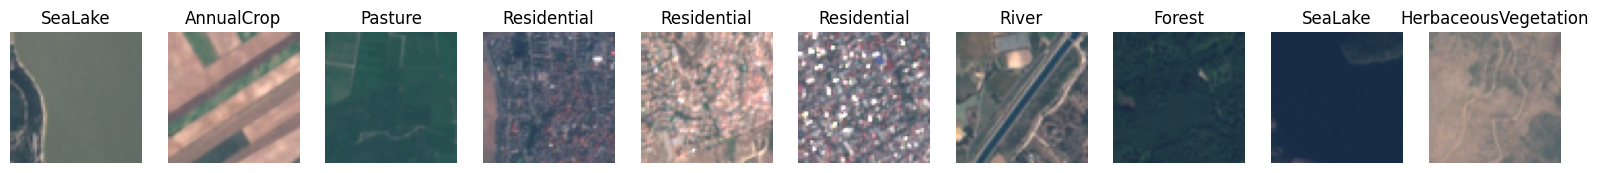

In [12]:
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=10, figsize=(20, 3))
for ax in axs:
    image, label = dataset[random.randint(0, len(dataset)-1)]
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(dataset.classes[label])

Посчитаем статистику RGB каналам. Считать std как среднее от стандартных отклонений по batch-ам не корректно. Поэтому использую
https://stackoverflow.com/questions/10365119/mean-value-and-standard-deviation-of-a-very-huge-data-set

In [13]:
import numpy as np

from torch.utils.data import DataLoader
from tqdm import tqdm


def get_mean_and_std(dataset):
    loader = DataLoader(dataset, batch_size=4500, shuffle=False) 
    sum_channel = 0
    squared_sum_channel = 0
    n = len(dataset) * dataset[0][0].shape[1] * dataset[0][0].shape[2]
    for images, lables in tqdm(loader):
        # sum of values
        sum_channel += images.sum(dim=(0, 2, 3))  
        # sum of squared values
        squared_sum_channel += images.pow(exponent=2).sum(dim=(0, 2, 3))  
    mean = sum_channel / n  # E[x]
    std = (squared_sum_channel / n - mean**2).sqrt()  # E[x^2] - (E[X])^2
    return mean.numpy(), std.numpy()

In [14]:
from torchvision import transforms

dataset.transform = transforms.Compose([
    transforms.ToTensor()
])

mean, std = get_mean_and_std(dataset)

print("Mean", mean)
print("STD", std)

dataset.transform.transforms.append(transforms.Normalize(mean, std))

100%|██████████| 6/6 [00:15<00:00,  2.50s/it]

Mean [0.34436905 0.3802921  0.40777746]
STD [0.20368496 0.13663732 0.11484403]


 Учится долго, поэтому решила бахнуть левчика https://github.com/lucidrains/lion-pytorch

In [15]:
!pip install lion-pytorch

from lion_pytorch import Lion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Хочу изменить правила на изменение beta при генерации. Источник кода и вдохновения: https://huggingface.co/blog/annotated-diffusion

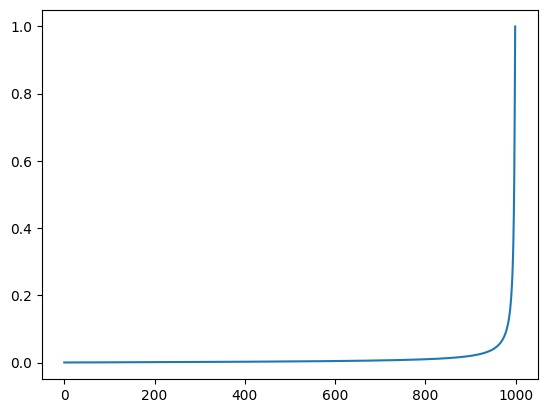

In [16]:
import torch
import matplotlib.pyplot as plt

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


plt.plot(cosine_beta_schedule(1000))

In [17]:
def ddpm_schedules_cosine(T: int) -> dict[str, torch.Tensor]:
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    beta_t = cosine_beta_schedule(T)
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

Присовокупим его к DDPM. При наследовании почему-то падает cuda. Пока не поняла почему

In [18]:
from torch import nn

class DDPMCOS(DDPM):
    def __init__(
        self,
        eps_model: nn.Module,
        betas: tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super().__init__(eps_model, betas, n_T, criterion)

        # register_buffer allows us to freely access these tensors by name. It helps device placement.
        for k, v in ddpm_schedules_cosine(n_T).items():
            self.register_buffer(k, v)

И метрику расстояния поменяла

In [19]:
import torch 
base_model = NaiveUnet(3, 3, n_feat=128)

model = DDPMCOS(eps_model=base_model, 
                betas=(1e-4, 0.02), n_T=1000, 
                criterion=nn.SmoothL1Loss()) # Huber loss
dataloader = DataLoader(dataset, batch_size=128//4, shuffle=True)
optimizer = Lion(model.parameters(), lr=1e-5)

In [20]:
path = "/content/gdrive/MyDrive/euro_sat_experiment_1/"
!mkdir -p /content/gdrive/MyDrive/euro_sat_experiment_1/result

Код на обучение, основа https://github.com/cloneofsimo/minDiffusion/blob/master/train_cifar10.py убрала захардкоженное.

In [23]:
from torch import nn
from typing import Optional

from torchvision.utils import save_image, make_grid


def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: type,
    n_epoch: int = 100, 
    device: str = "cuda", 
) -> None:

    for i in range(n_epoch):
        print(f"Epoch {i} : ")
        model.to(device).train()

        progress_bar = tqdm(dataloader)
        loss_ema = None
        for x, _ in progress_bar:
            optimizer.zero_grad()
            x = x.to(device)
            loss = model(x)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            progress_bar.set_description(f"loss: {loss_ema:.4f}")
            optimizer.step()

        model.eval()
        with torch.no_grad():
            xh = model.sample(8, (3, 64, 64), device)
            xset = torch.cat([xh.to('cpu'), x[:8].to('cpu')], dim=0)
            grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
            save_image(grid, f"{path}result/ddpm_sample{i}.png")
            # save model
            torch.save(model.state_dict(), f"{path}model.pth")


In [24]:
train(model, dataloader, optimizer, n_epoch=100)

Epoch 0 : 


loss: 0.0298: 100%|██████████| 844/844 [05:12<00:00,  2.70it/s]


Epoch 1 : 


loss: 0.0263: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 2 : 


loss: 0.0228: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 3 : 


loss: 0.0243: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 4 : 


loss: 0.0220: 100%|██████████| 844/844 [05:10<00:00,  2.72it/s]


Epoch 5 : 


loss: 0.0211: 100%|██████████| 844/844 [05:10<00:00,  2.72it/s]


Epoch 6 : 


loss: 0.0234: 100%|██████████| 844/844 [05:10<00:00,  2.72it/s]


Epoch 7 : 


loss: 0.0227: 100%|██████████| 844/844 [05:10<00:00,  2.72it/s]


Epoch 8 : 


loss: 0.0186: 100%|██████████| 844/844 [05:10<00:00,  2.72it/s]


Epoch 9 : 


loss: 0.0191: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 10 : 


loss: 0.0213: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 11 : 


loss: 0.0214: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 12 : 


loss: 0.0222: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 13 : 


loss: 0.0215: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 14 : 


loss: 0.0203: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 15 : 


loss: 0.0209: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 16 : 


loss: 0.0222: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 17 : 


loss: 0.0165: 100%|██████████| 844/844 [05:13<00:00,  2.69it/s]


Epoch 18 : 


loss: 0.0193: 100%|██████████| 844/844 [05:12<00:00,  2.70it/s]


Epoch 19 : 


loss: 0.0197: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 20 : 


loss: 0.0196: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 21 : 


loss: 0.0251: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 22 : 


loss: 0.0196: 100%|██████████| 844/844 [05:12<00:00,  2.70it/s]


Epoch 23 : 


loss: 0.0180: 100%|██████████| 844/844 [05:12<00:00,  2.70it/s]


Epoch 24 : 


loss: 0.0224: 100%|██████████| 844/844 [05:12<00:00,  2.70it/s]


Epoch 25 : 


loss: 0.0197: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 26 : 


loss: 0.0178: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 27 : 


loss: 0.0193: 100%|██████████| 844/844 [05:12<00:00,  2.70it/s]


Epoch 28 : 


loss: 0.0170: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 29 : 


loss: 0.0171: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 30 : 


loss: 0.0185: 100%|██████████| 844/844 [05:11<00:00,  2.71it/s]


Epoch 31 : 


loss: 0.0190: 100%|██████████| 844/844 [05:12<00:00,  2.70it/s]


Epoch 32 : 


loss: 0.0169: 100%|██████████| 844/844 [05:12<00:00,  2.70it/s]


Epoch 33 : 


loss: 0.0177: 100%|██████████| 844/844 [05:13<00:00,  2.69it/s]


Epoch 34 : 


loss: 0.0182: 100%|██████████| 844/844 [05:13<00:00,  2.70it/s]


Epoch 35 : 


loss: 0.0198: 100%|██████████| 844/844 [05:12<00:00,  2.70it/s]


Epoch 36 : 


loss: 0.0157: 100%|██████████| 844/844 [05:12<00:00,  2.70it/s]


Epoch 37 : 


loss: 0.0202: 100%|██████████| 844/844 [05:13<00:00,  2.70it/s]


Epoch 38 : 


loss: 0.0166: 100%|██████████| 844/844 [05:12<00:00,  2.70it/s]


Epoch 39 : 


loss: 0.0161: 100%|██████████| 844/844 [05:13<00:00,  2.69it/s]


Epoch 40 : 


loss: 0.0184: 100%|██████████| 844/844 [05:13<00:00,  2.69it/s]


Epoch 41 : 


loss: 0.0194: 100%|██████████| 844/844 [05:15<00:00,  2.68it/s]


Epoch 42 : 


loss: 0.0166: 100%|██████████| 844/844 [05:14<00:00,  2.69it/s]


Epoch 43 : 


loss: 0.0176: 100%|██████████| 844/844 [05:14<00:00,  2.68it/s]


Epoch 44 : 


loss: 0.0213: 100%|██████████| 844/844 [05:13<00:00,  2.69it/s]


Epoch 45 : 


loss: 0.0162:  63%|██████▎   | 528/844 [03:16<01:57,  2.68it/s]


KeyboardInterrupt: ignored

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()